# Yolo V8 + SAM

We will see how to identify an object from an image using `Yolo`, then segmant that object using `SAM` and finally removing the background.

#### Install the required dependencies

In [1]:
!pip install ultralytics

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.9/756.9 kB 10.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

#### Import the things we need

In [2]:
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.2/78.2 GB disk)


#### Detect object using Yolo V8n

In [4]:
!yolo predict model=yolov8n.pt source='/content/temp3.jpg'

Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/temp3.jpg: 384x640 1 teddy bear, 102.8ms
Speed: 5.1ms preprocess, 102.8ms inference, 2969.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


#### See the image

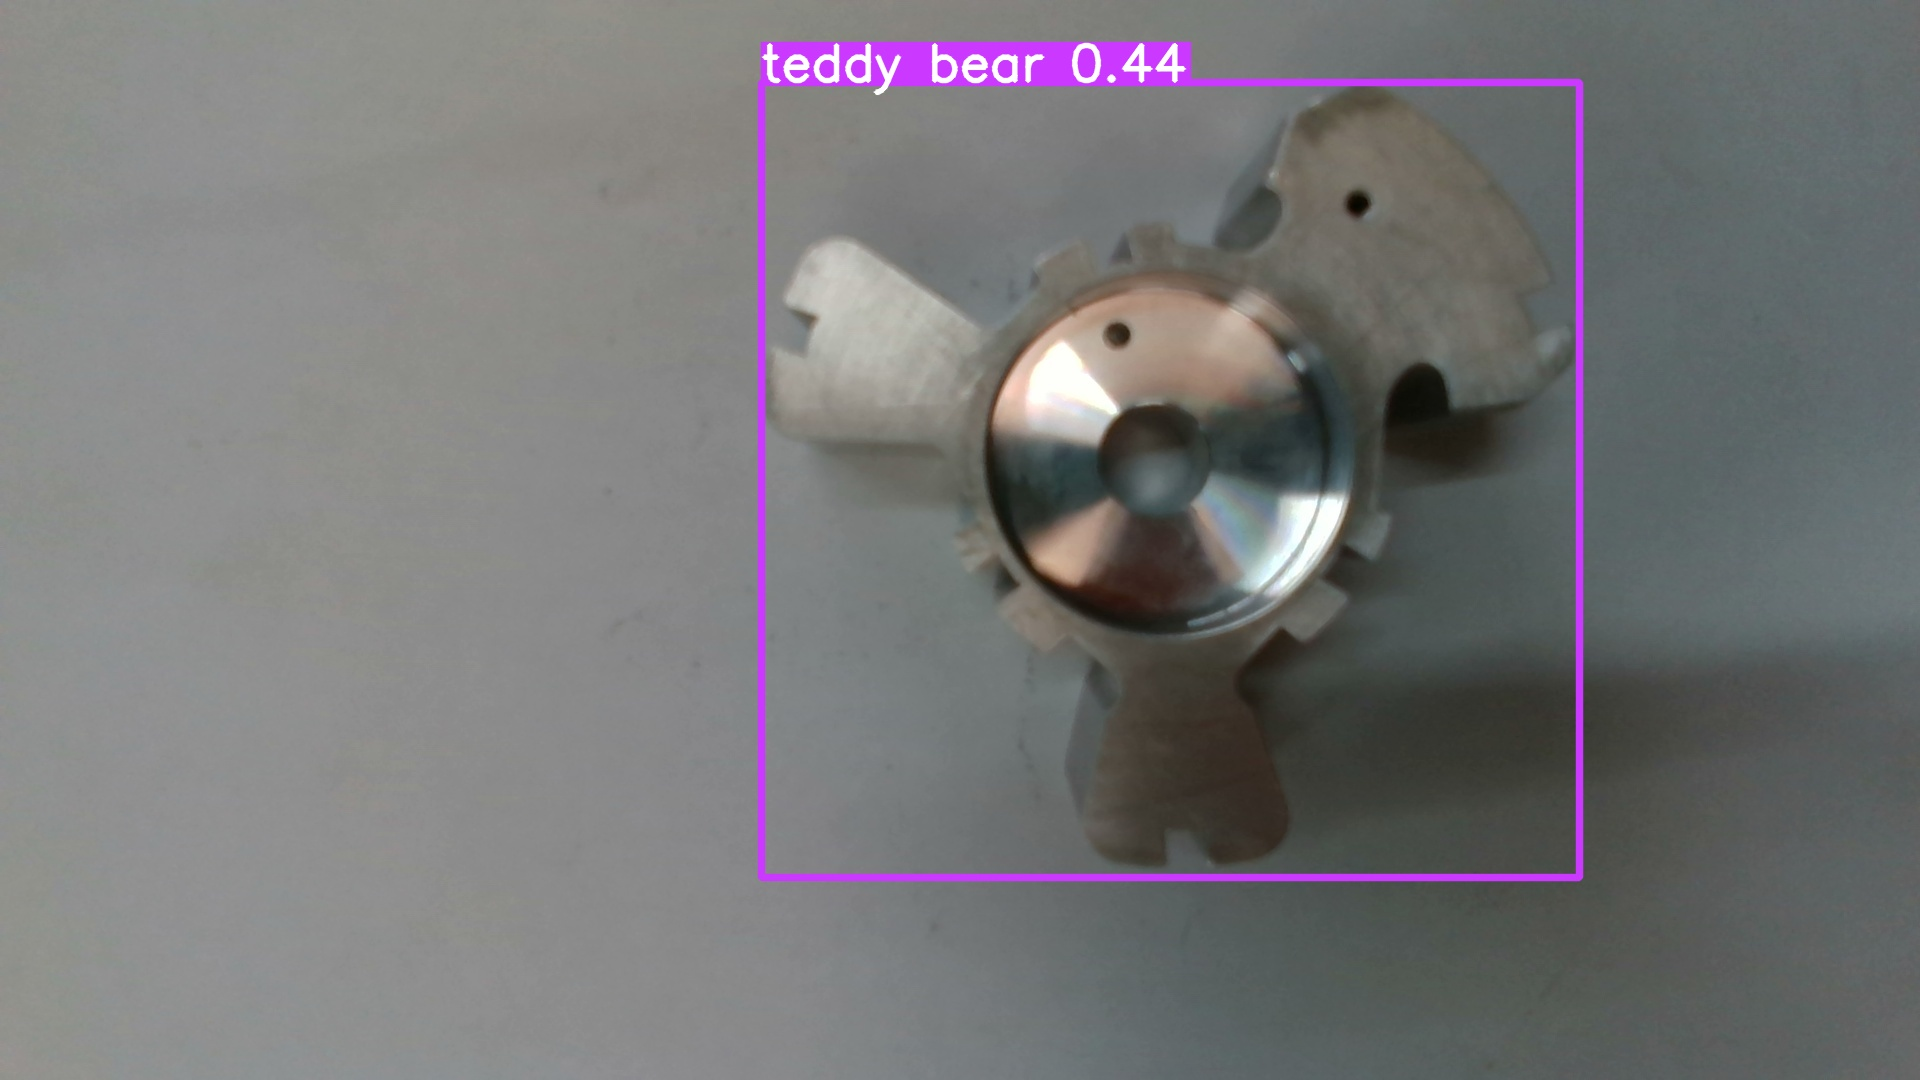

In [5]:
Image(filename='/content/runs/detect/predict/temp3.jpg', height=600)

In [6]:
model = YOLO('/content/yolov8n.pt')
results = model.predict(source='/content/temp3.jpg', conf=0.25)


image 1/1 /content/temp3.jpg: 384x640 1 teddy bear, 104.6ms
Speed: 4.5ms preprocess, 104.6ms inference, 500.2ms postprocess per image at shape (1, 3, 384, 640)


In [7]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [8]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[761.4910278320312, 82.16793823242188, 1579.166748046875, 877.9951171875]

In [9]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [10]:
image = cv2.cvtColor(cv2.imread('/content/temp3.jpg'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

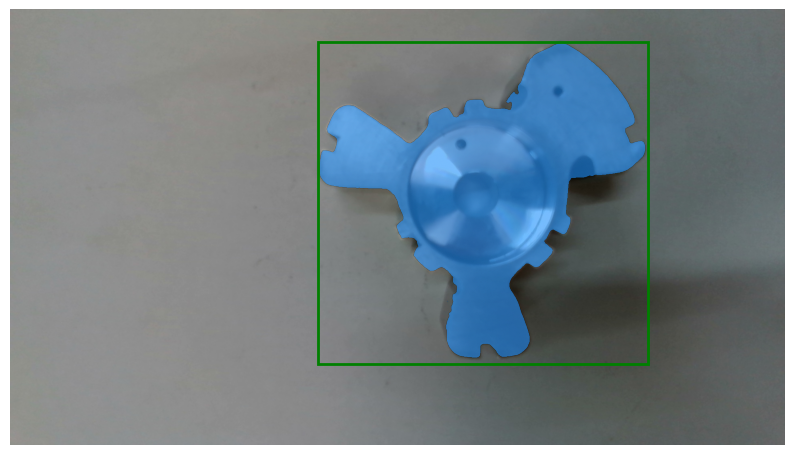

In [12]:
input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

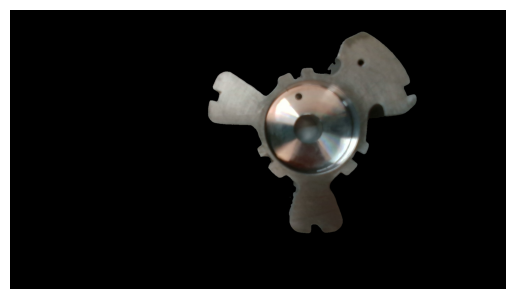

In [13]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 0

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


image 1/1 /content/temp3.jpg: 384x640 1 teddy bear, 12.0ms
Speed: 3.3ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


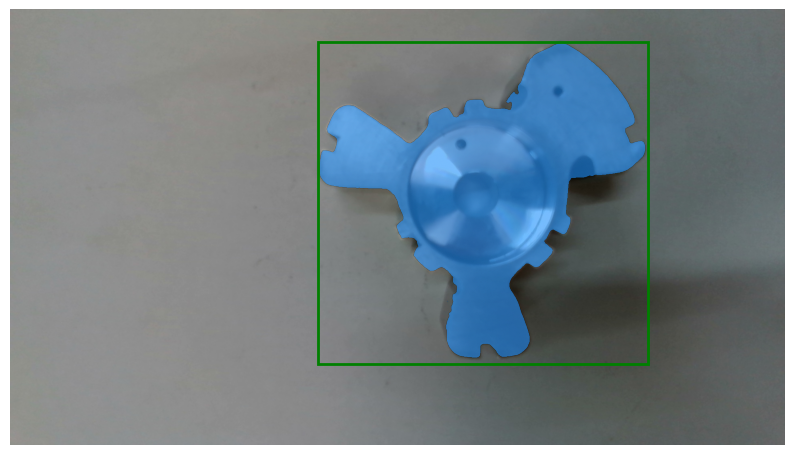

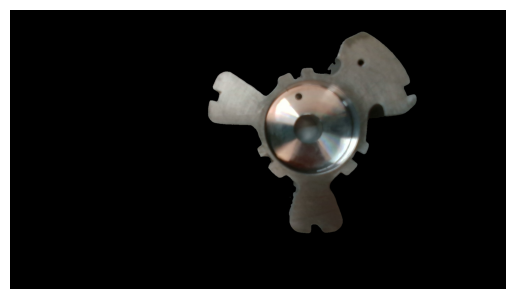

In [14]:
image_path = '/content/temp3.jpg'

results = model.predict(source=image_path, conf=0.25)

for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

predictor.set_image(image)

input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 0

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


image 1/1 /content/temp3.jpg: 384x640 1 teddy bear, 29.0ms
Speed: 3.2ms preprocess, 29.0ms inference, 9.4ms postprocess per image at shape (1, 3, 384, 640)


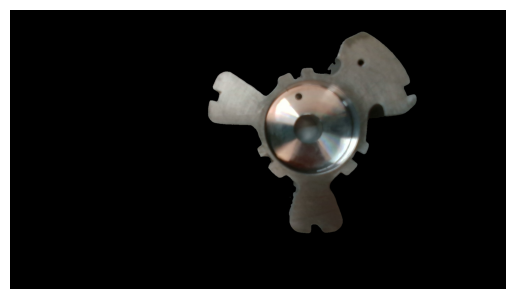

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_masked_image(image_path, model, predictor, conf_threshold=0.25, save_path='masked_image.jpg'):
    # Load the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Use the model to predict bounding boxes
    results = model.predict(source=image_path, conf=conf_threshold)

    # Extract bounding box coordinates
    for result in results:
        boxes = result.boxes
    bbox = boxes.xyxy.tolist()[0]

    # Set the image for the predictor
    predictor.set_image(image)

    # Convert bounding box to numpy array
    input_box = np.array(bbox)

    # Use predictor to predict masks
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    # Create binary mask from segmentation mask
    segmentation_mask = masks[0]
    binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

    # Create white background image
    white_background = np.ones_like(image) * 0

    # Combine original image with binary mask
    new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

    # Convert to uint8
    new_image_uint8 = new_image.astype(np.uint8)

    # Save the masked image
    cv2.imwrite(save_path, cv2.cvtColor(new_image_uint8, cv2.COLOR_RGB2BGR))

    # Display the masked image (optional)
    plt.imshow(new_image_uint8)
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/temp3.jpg'
save_path = '/content/masked_image.jpg'  # Specify save path for the masked image
save_masked_image(image_path, model, predictor, conf_threshold=0.25, save_path=save_path)


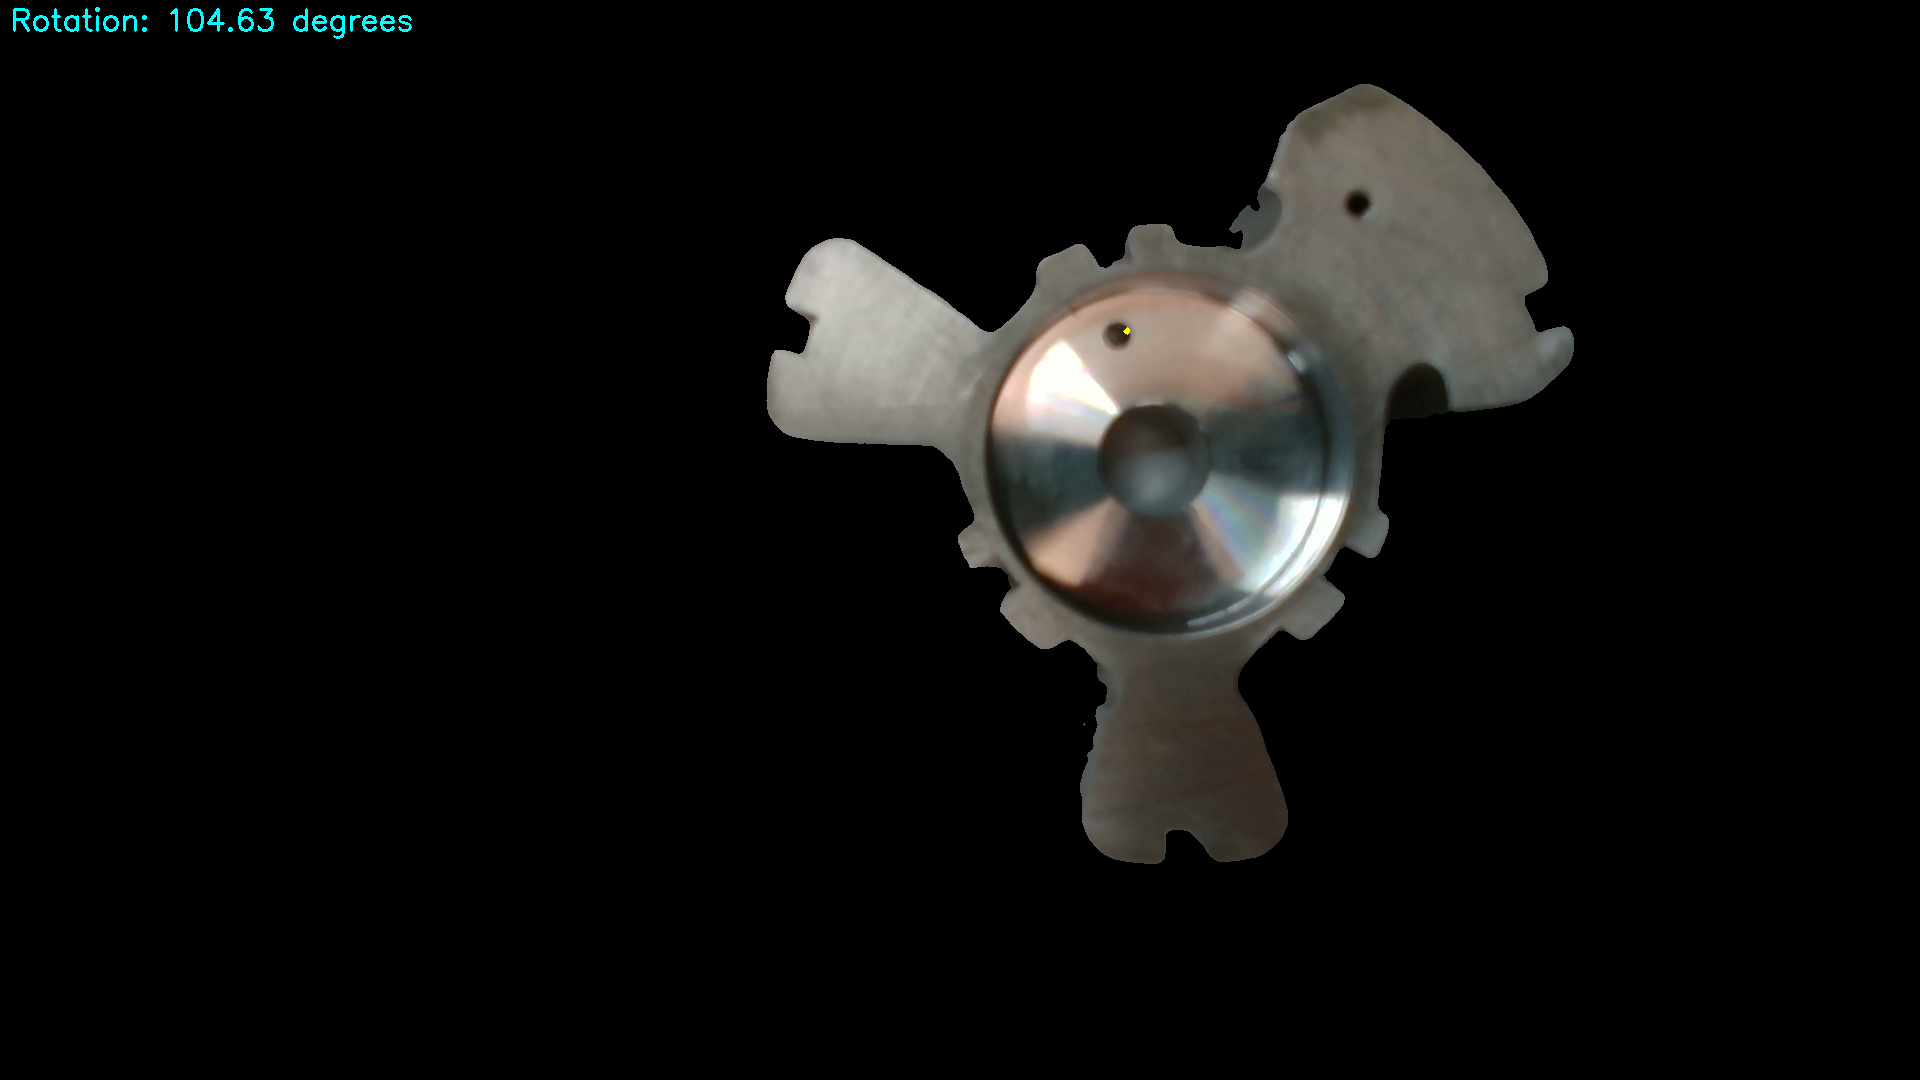

In [22]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

def find_orientation(template_path, test_path):
    # Load images
    template = cv2.imread(template_path, 0)  # Load in grayscale
    test_img = cv2.imread(test_path)
    test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(template, None)
    kp2, des2 = orb.detectAndCompute(test_gray, None)

    # Create BFMatcher object and match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)
    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt

    # Find homography
    H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography to transform the template image corners to the test image
    h, w = template.shape
    corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # Draw boundary
    boundary = np.int32(transformed_corners)
    # Drawing the polygon around the detected object more visibly
    cv2.polylines(test_img, [boundary], True, (0, 255, 255), 3)  # Changed color and thickness

    # Calculate rotation angle
    theta = -np.arctan2(H[0, 1], H[0, 0]) * (180 / np.pi)

    # Annotate test image with rotation
    cv2.putText(test_img, f"Rotation: {theta:.2f} degrees", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)  # Changed text color

    # Display the result using cv2_imshow (for Google Colab)
    cv2_imshow(test_img)

# Example usage
find_orientation('/content/blue2.jpg', '/content/masked_image.jpg')
